# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1g-w9mDXAVuQSz4nL8TqZgo02L0UqKpi5?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import zipfile
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm

#Unzip file
with zipfile.ZipFile("/content/Lab3 Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")
torch.cuda.is_available()



True

In [ ]:
def to_one_hot(y):
  one_hot = np.zeros(9)
  one_hot[y] = 1
  return torch.from_numpy(one_hot)
#Code from Lab2
transform = transforms.Compose(
    [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder(root="/content/Lab3_Gestures_Summer", transform=transform, target_transform=to_one_hot)
image, label = dataset[0]

print(f"First Image: {image}")
print(f"Label: {label}")

print(f"Classes: {dataset.classes}")
print(f"Class to Label mapping: {dataset.class_to_idx}")

first_20_labels = [dataset[i][1] for i in range(20)]
print(f"First 20 labels: {first_20_labels}") #Data is sorted





First Image: tensor([[[0.6706, 0.6784, 0.6863,  ..., 0.5843, 0.6157, 0.6000],
         [0.6784, 0.6941, 0.7098,  ..., 0.5765, 0.5765, 0.6078],
         [0.6706, 0.6863, 0.7412,  ..., 0.6157, 0.5765, 0.6235],
         ...,
         [0.6784, 0.5765, 0.6235,  ..., 0.2706, 0.2706, 0.2471],
         [0.6235, 0.5922, 0.5922,  ..., 0.2314, 0.2471, 0.2392],
         [0.6392, 0.6549, 0.6784,  ..., 0.2235, 0.2627, 0.2314]],

        [[0.6471, 0.6549, 0.6627,  ..., 0.5608, 0.5922, 0.5765],
         [0.6549, 0.6706, 0.6863,  ..., 0.5529, 0.5529, 0.5843],
         [0.6471, 0.6627, 0.7176,  ..., 0.5922, 0.5529, 0.6000],
         ...,
         [0.6549, 0.5529, 0.6000,  ..., 0.2157, 0.2157, 0.1922],
         [0.6000, 0.5686, 0.5686,  ..., 0.1922, 0.1922, 0.1843],
         [0.6157, 0.6314, 0.6549,  ..., 0.1843, 0.2078, 0.1765]],

        [[0.5922, 0.6000, 0.6078,  ..., 0.5059, 0.5373, 0.5216],
         [0.6000, 0.6157, 0.6314,  ..., 0.4980, 0.4980, 0.5294],
         [0.5922, 0.6078, 0.6627,  ..., 0.537

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(batch_size):
  indices = list(range(len(dataset)))
  np.random.seed(1000) #Fix seed for reproducibility
  np.random.shuffle(indices) #Shuffle to do Random sampling without replacement

  #Cutting points
  train_val_cut = math.floor(len(dataset)*0.7) #Between train and validation
  val_test_cut = train_val_cut + math.floor(len(dataset)*0.15) #Between validation and test

  #I used 70%, 15%, 15% split
  train_indices = indices[:train_val_cut]
  val_indices = indices[train_val_cut:val_test_cut]
  test_indices = indices[val_test_cut:]

  #Random inside train, validation, and test set
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1, sampler=train_sampler)
  val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1, sampler=val_sampler)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1, sampler=test_sampler)
  return (train_loader, val_loader, test_loader)

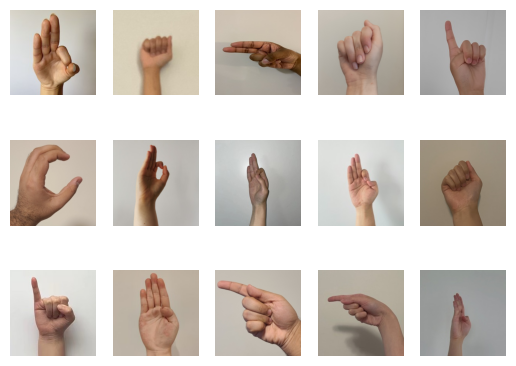

In [ ]:
train_loader, val_loader, test_loader = load_data(1)

#Code from Lab2, Displaying 15 images from train_loader of batch size 1
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

In [ ]:
print(f"Number of Train images: {len(train_loader)}") #This works because we have batch_size = 1
print(f"Number of Validation images: {len(val_loader)}")
print(f"Number of Test images: {len(test_loader)}")
print(f"Total images: {len(dataset)}")

Number of Train images: 1553
Number of Validation images: 332
Number of Test images: 334
Total images: 2219


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
#Considering the dataset is not very large, I will not use large architectures
class myCNN(nn.Module):
  def __init__(self, name):
    super(myCNN, self).__init__()
    self.name = name
    self.conv1 = nn.Conv2d(3, 5, 3, stride = 2, padding = 1)
    self.conv2 = nn.Conv2d(5, 8, 3, stride = 2, padding = 1)
    self.conv3 = nn.Conv2d(8, 8, 3, padding = "same")
    self.pool = nn.MaxPool2d(2, stride=2)
    self.fc1 = nn.Linear(7*7*8,16) #7*7*8 is the dimensions after the last pooling
    self.fc2 = nn.Linear(16, 9)
    self.latent_dim = 7*7*8
  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, self.latent_dim)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x
#I used a total of 8 layers: 3 convolutional, 3 pooling, and 2 fully-connected.
#I used 2*2, stride = 2 max pooling for all pooling layers
#I used ReLU after every convolutional layers, and fully connected layers (except the output layer)
#The structure is composed of convolutional layer followed by pooling 3 times, followed by 2 fully connected layers
#I used 5 and 8 as my output channels
#7533 total parameters, including biases

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def plot_loss(train_loss_record, val_loss_record, start = None, end = None):
    if start == None and end == None:
      keys = list(train_loss_record.keys())
      train_loss = list(train_loss_record.values())
      val_loss = list(val_loss_record.values())
    else:
      keys = list(train_loss_record.keys())[start:end]
      train_loss = list(train_loss_record.values())[start:end]
      val_loss = list(val_loss_record.values())[start:end]
    plt.figure(figsize=(10, 6))

    plt.plot(keys,train_loss, label='Training Loss')

    plt.plot(keys,val_loss, label='Validation Loss', linestyle='--')

    plt.xlabel('Iteration (x50 batches)')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')

    plt.legend()
    plt.grid(True)

    plt.show()

def evaluate(net,loader,criterion):
    total_loss = 0
    total_num = 0

    total_err = 0
    total_num_err = 0
    for x,y in loader:
      y_pred = net(x)
      loss = criterion(y_pred,y)
      total_loss += loss.item()
      total_num += 1 #Average across every batch

      total_num_err += len(y) #Average across all the labels
      y_pred_prob = F.softmax(y_pred, dim=1)

      #The class with maximum probability will be our prediction
      pred = torch.argmax(y_pred_prob, dim=1)
      true = torch.argmax(y, dim=1)

      #Compare true label with predicted label
      corr = pred != true
      total_err += int(corr.sum())


    return total_loss/total_num, total_err/total_num_err

def get_model_name(name, batch_size, learning_rate, epoch, batch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}_batch{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch,
                                                   batch)
    return path


In [ ]:
#I used Cross Entropy Loss for multiclass classification
#I used Adam optimizer to include both momentum and adaptive learning rate
def train(net, batch_size, learning_rate, num_epochs, train_loader=None, val_loader=None, show_loss = 1):
  torch.manual_seed(0)
  if train_loader == None and val_loader == None:
    train_loader, val_loader, test_loader = load_data(batch_size)

  #Cross Entropy Loss and Adam optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  #Record for every 50 batch
  train_loss_record = dict()
  val_loss_record = dict()

  for i in tqdm(range(num_epochs)):
    train_loss = 0 #set train_loss = 0 at the start of each epoch
    for j,(x,y) in enumerate(train_loader):
      y_pred = net(x)
      loss = criterion(y_pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() #increment train_loss by every batch
      if (j+1) % 50 == 0: #Compute average loss every 50 batch
        if show_loss == 1:
          print(f"loss at epoch:{i}, batch{j+1}: {loss.item()}")
        avg_loss = train_loss/50
        train_loss_record[f"({i},{j+1})"] = avg_loss #save train average loss in dictionary
        train_loss = 0
        val_loss = evaluate(net,val_loader,nn.CrossEntropyLoss())[0] #get validation loss from the current model
        val_loss_record[f"({i},{j+1})"] = val_loss

        #Save model every 50 batch
        model_path = get_model_name(net.name, batch_size, learning_rate, i, j+1)
        torch.save(net.state_dict(), model_path)
  return (train_loss_record, val_loss_record)


  0%|          | 0/3 [00:00<?, ?it/s]

loss at epoch:0, batch50: 2.1368369460105896
loss at epoch:0, batch100: 2.158970594406128
loss at epoch:0, batch150: 2.21500226855278


 33%|███▎      | 1/3 [00:09<00:19,  9.61s/it]

loss at epoch:1, batch50: 1.7820181921124458
loss at epoch:1, batch100: 1.3164921626448631
loss at epoch:1, batch150: 1.373902183957398


 67%|██████▋   | 2/3 [00:17<00:08,  8.55s/it]

loss at epoch:2, batch50: 0.7152413874864578
loss at epoch:2, batch100: 1.2706579994410276
loss at epoch:2, batch150: 0.9560740906745195


100%|██████████| 3/3 [00:26<00:00,  8.79s/it]


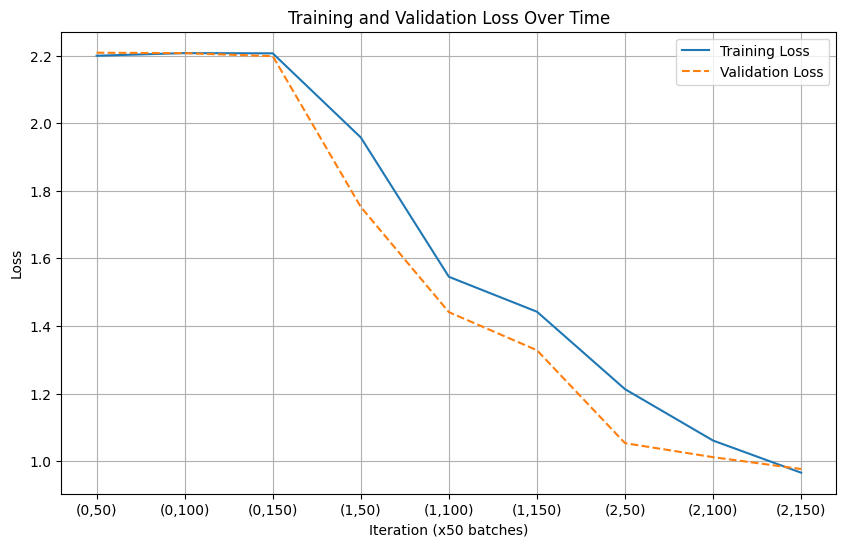

In [ ]:
CNN_Net = myCNN("myCNN")
train_loss_record, val_loss_record = train(CNN_Net, 8, 0.001, 3)
plot_loss(train_loss_record, val_loss_record)

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
torch.manual_seed(0)

#Construct small dataset of 100 images
train_loader, val_loader, test_loader = load_data(100)
train_iterator = iter(train_loader)
first_batch = [next(train_iterator)]

#Train with batch size = entire small dataset
CNN_Net = myCNN("Overfit")
train(CNN_Net,100,0.001,200,first_batch,val_loader)




100%|██████████| 200/200 [00:41<00:00,  4.78it/s]


({}, {})

In [ ]:
#0 misprediction
print(evaluate(CNN_Net, first_batch, nn.CrossEntropyLoss())[1])

0.0


### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

In [ ]:
#Learning Rate, Number of output channels, Number of epochs

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

100%|██████████| 20/20 [02:38<00:00,  7.92s/it]


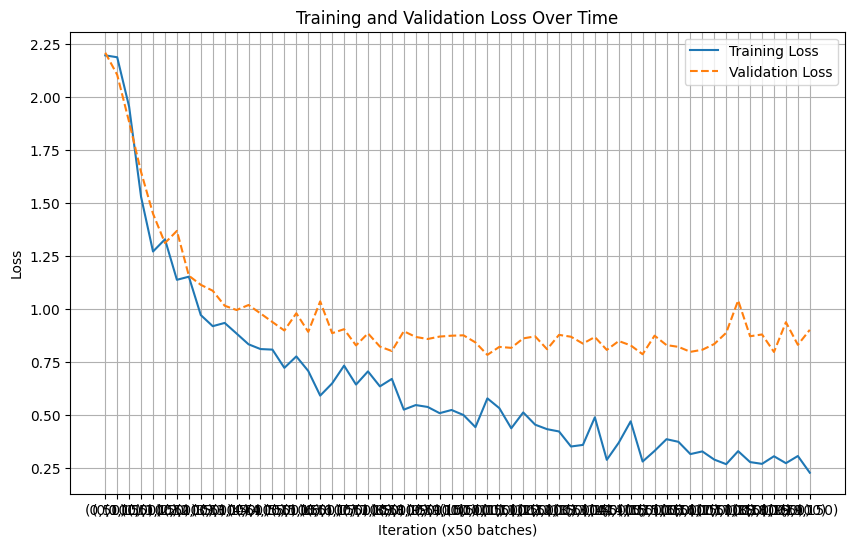

In [ ]:
#[LR=0.001, Default CNN, 20], increase num epochs because we used 3 epochs before
#and it still hasn't passed the point of overfitting
CNN_Net = myCNN("Model1")
train_loss_record, val_loss_record = train(CNN_Net, 8, 0.001, 20,show_loss=0)
plot_loss(train_loss_record, val_loss_record)

100%|██████████| 15/15 [02:16<00:00,  9.09s/it]


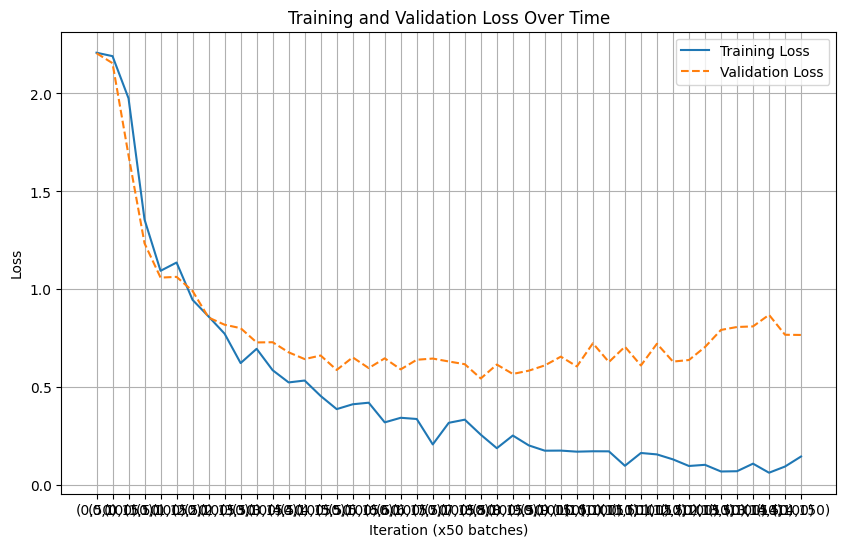

In [ ]:
#[LR=0.001, Increase output channels, 15], increase output channels and reduce
#num_epochs by a little because the model is more complex

#Original Architecture
# self.conv1 = nn.Conv2d(3, 5, 3, stride = 2, padding = 1)
# self.conv2 = nn.Conv2d(5, 8, 3, stride = 2, padding = 1)
# self.conv3 = nn.Conv2d(8, 8, 3, padding = "same")

#Setting up new Architecture
CNN_Net = myCNN("Model2")
CNN_Net.conv1 = nn.Conv2d(3,8,3,stride=2,padding=1)
CNN_Net.conv2 = nn.Conv2d(8,16,3,stride=2,padding=1)
CNN_Net.conv3 = nn.Conv2d(16,16,3, padding="same")
CNN_Net.fc1 = nn.Linear(7*7*16,16)
CNN_Net.latent_dim = 7*7*16

train_loss_record, val_loss_record = train(CNN_Net, 8, 0.001, 15,show_loss=0)
plot_loss(train_loss_record, val_loss_record)





100%|██████████| 15/15 [02:12<00:00,  8.85s/it]


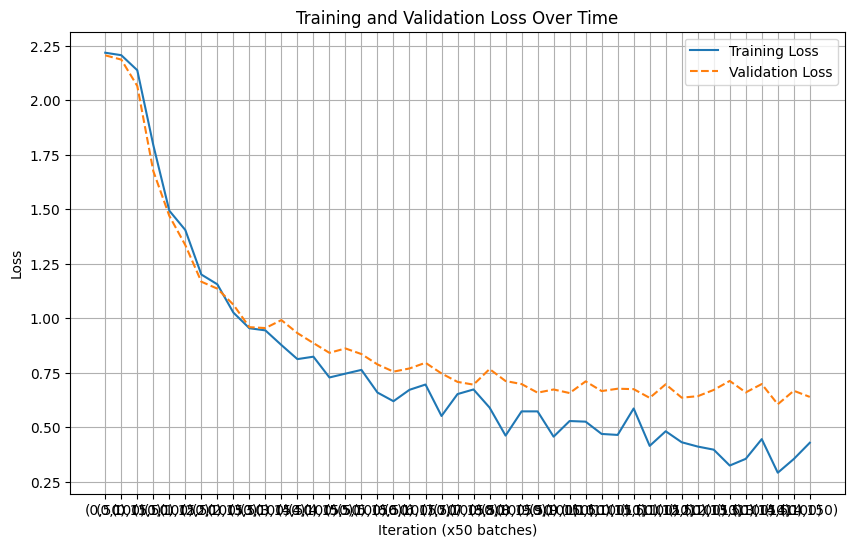

In [ ]:
#[LR=0.0005, Increase output channels, 15], reduce learning rate because the graphs
# show some signs of overfitting in the middle.

#Reset CNN
CNN_Net = myCNN("Model3")
CNN_Net.conv1 = nn.Conv2d(3,8,3,stride=2,padding=1)
CNN_Net.conv2 = nn.Conv2d(8,16,3,stride=2,padding=1)
CNN_Net.conv3 = nn.Conv2d(16,16,3, padding="same")
CNN_Net.fc1 = nn.Linear(7*7*16,16)
CNN_Net.latent_dim = 7*7*16

train_loss_record, val_loss_record = train(CNN_Net, 8, 0.0005, 15,show_loss=0)
plot_loss(train_loss_record, val_loss_record)


100%|██████████| 20/20 [03:33<00:00, 10.67s/it]


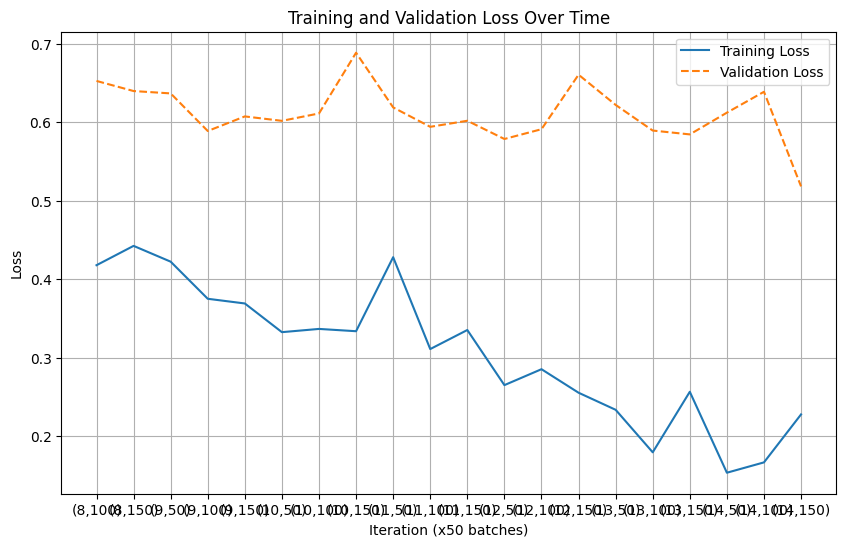

In [ ]:
#Increase output channels and num_epochs with low learning rate

CNN_Net = myCNN("Model4")
CNN_Net.conv1 = nn.Conv2d(3,12,3,stride=2,padding=1)
CNN_Net.conv2 = nn.Conv2d(12,24,3,stride=2,padding=1)
CNN_Net.conv3 = nn.Conv2d(24,24,3, padding="same")
CNN_Net.fc1 = nn.Linear(7*7*24,16)
CNN_Net.latent_dim = 7*7*24

train_loss_record, val_loss_record = train(CNN_Net, 8, 0.0005, 20,show_loss=0)
plot_loss(train_loss_record, val_loss_record, start=25, end=45)


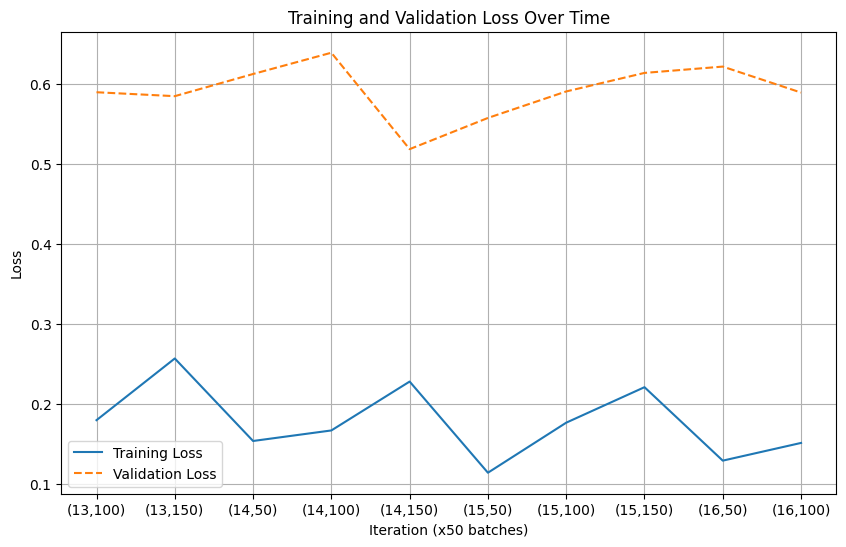

In [ ]:
plot_loss(train_loss_record, val_loss_record, start=40, end=50)


### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
#The last model which uses lr=0.0005, num_epochs=20, and more complex architecture is the best model
#because it is able to achieve the lowest validation loss at around 0.5.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
#Get the weights of epoch = 14, batch = 150 of Model4
#name, batch_size, learning_rate, epoch, batch
Best_Net = myCNN("Best_Model")
Best_Net.conv1 = nn.Conv2d(3,12,3,stride=2,padding=1)
Best_Net.conv2 = nn.Conv2d(12,24,3,stride=2,padding=1)
Best_Net.conv3 = nn.Conv2d(24,24,3, padding="same")
Best_Net.fc1 = nn.Linear(7*7*24,16)
Best_Net.latent_dim = 7*7*24
model_path = get_model_name("Model4", batch_size=8, learning_rate=0.0005, epoch=14, batch=150)
state = torch.load(model_path)
Best_Net.load_state_dict(state)



<ipython-input-29-306368b073d4>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [ ]:
train_loader, val_loader, test_loader = load_data(1)

accuracy = 1 - evaluate(Best_Net, test_loader ,nn.CrossEntropyLoss())[1]
print(f"Accuracy: {accuracy*100}%")

Accuracy: 81.437125748503%


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 150MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
train_loader, val_loader, test_loader = load_data(8)

train_data = []
val = []
test = []
#torch = torch.from_numpy(torch.detach().numpy())

for x,y in train_loader:
  t = alexnet.features(x)
  t = torch.from_numpy(t.detach().numpy())
  train_data.append((t,y))
for x,y in val_loader:
  t = alexnet.features(x)
  t = torch.from_numpy(t.detach().numpy())
  val.append((t,y))
for x,y in test_loader:
  t = alexnet.features(x)
  t = torch.from_numpy(t.detach().numpy())
  test.append((t,y))


### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
class CNN(nn.Module):
  def __init__(self,name):
    super(CNN, self).__init__()
    self.name = name
    self.conv1 = nn.Conv2d(256,256, 3, padding="same")
    self.fc1 = nn.Linear(256,64)
    self.fc2 = nn.Linear(64,9)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = torch.mean(x, dim=(2, 3))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x
model = CNN("pretrained")
# output = model(features)
# prob = F.softmax(output)

#4 layers: 1 convolutional, 1 global average pooling, 2 fully connected
#I used global average pooling before entering fully connected and ReLU activation function
#I used the same number of channels as the input
#607,113 number of parameters, including biases

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

100%|██████████| 20/20 [01:28<00:00,  4.42s/it]


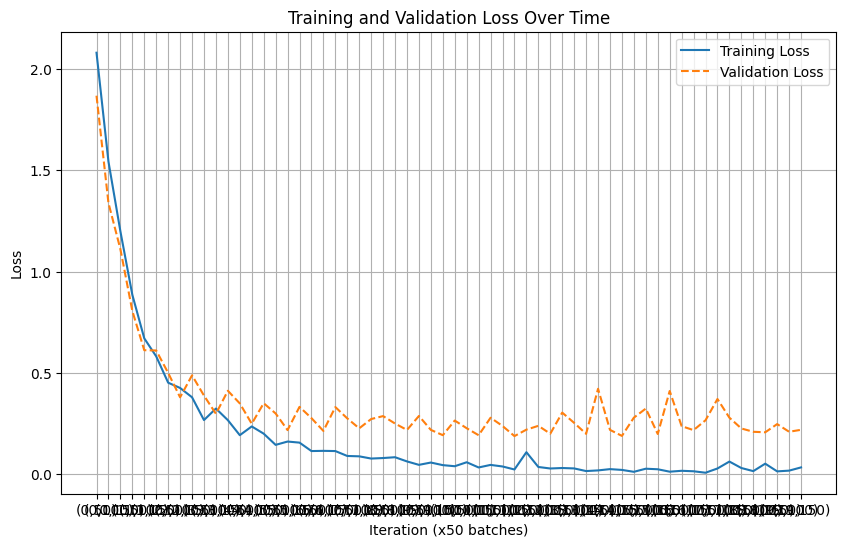

In [ ]:
#torch = torch.from_numpy(torch.detach().numpy())
train_loss_record, val_loss_record = train(model, 8, 0.00075, 20,show_loss=0, train_loader=train_data,val_loader=val)
plot_loss(train_loss_record, val_loss_record)


In [ ]:
val_loss = torch.tensor(list(val_loss_record.values()))
min_index = torch.argmin(val_loss)

val_key = list(val_loss_record.keys())
val_key[min_index] #This is the record of the best model

'(11,150)'

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
#Get the weights of epoch = 11, batch = 150
#name, batch_size, learning_rate, epoch, batch
Best_PNet = CNN("Best_Model")

model_path = get_model_name("pretrained", batch_size=8, learning_rate=0.00075, epoch=11, batch=150)
state = torch.load(model_path)
Best_PNet.load_state_dict(state)



<ipython-input-64-9e1ad66da602>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [ ]:

accuracy = 1 - evaluate(Best_PNet, test ,nn.CrossEntropyLoss())[1]
print(f"Accuracy: {accuracy*100}%")
#The Model with the help of pretrained network is able to achieve an accuracy of
#95.5% compared to 81.44% when not using pretrained network. This indicates a huge performance boost.

Accuracy: 95.50898203592814%


In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab3_Gesture_Recognition_Done.ipynb

[NbConvertApp] Converting notebook /content/Lab3_Gesture_Recognition_Done.ipynb to html
[NbConvertApp] Writing 1400261 bytes to /content/Lab3_Gesture_Recognition_Done.html
